In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import h5py
from scipy.optimize import curve_fit

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
def get_psd(h5_file_path='results/5-10-vahemman-rpoints/partial/l-32-d-4/shapes.h5',noise_key=None):
    psds = list()
    
    f = h5py.File(h5_file_path, "r")

    if type(noise_key) == type(None):
        noise_key = list(f.keys())[0]

    for seed in f[noise_key].keys():
        dataset = f[noise_key][seed]

        heights = dataset[-1]
        force = dataset.attrs['tau_exts'][-1]

        if len(heights.shape) > 1: # this means that it's a partial dislocation and we want to compute the cm.
            heights = np.mean(heights, axis=0)

        k = np.fft.fft(heights) / len(heights)
        fq = np.fft.fftfreq(len(k))

        psd = np.abs(k**2)
        psds.append(psd)
    
    psds = np.array(psds)
    psd = np.mean(psds, axis=0)
    return psd

In [3]:
from scipy.stats import linregress
from scipy.optimize import minimize_scalar

def plot_psd_with_fit(ax, h5_file, noise_key, label, fit_range=(0, 50), color=None):
    """
    Gets PSD data, plots it, and fits two lines with fixed slopes (-3.5 and -4).
    The intercepts are optimized, and k_star is the transition point between the two lines.
    """
    start, end = fit_range

    psd = get_psd(h5_file, noise_key=noise_key)
    
    # Plot PSD
    line, = ax.plot(psd[start:end], label=label, color=color)
    # Get the color of the line plot to use for the fit
    plot_color = line.get_color()

    x = np.arange(len(psd))
    
    # Define the range for the fit
    x_fit = x[start:end]
    y_fit = psd[start:end]

    # Fixed slopes
    slope1 = -3.5
    slope2 = -4.0

    # Perform regression with fixed slopes
    if len(x_fit) > 1 and len(y_fit) > 1:
        # Use indices where x_fit and y_fit are positive
        valid_indices = (x_fit > 0) & (y_fit > 0)
        
        if np.sum(valid_indices) > 1:
            log_x = np.log(x_fit[valid_indices])
            log_y = np.log(y_fit[valid_indices])
            
            # Find optimal k_star by minimizing residuals
            def residual_sum(k_break):
                if k_break <= start or k_break >= end:
                    return np.inf
                
                # First line: from start to k_break
                mask1 = (x_fit <= k_break) & valid_indices
                if np.sum(mask1) < 1:
                    return np.inf
                
                # Second line: from k_break to end
                mask2 = (x_fit > k_break) & valid_indices
                if np.sum(mask2) < 1:
                    return np.inf
                
                # Fit intercepts for fixed slopes
                log_x1 = log_x[mask1]
                log_y1 = log_y[mask1]
                log_x2 = log_x[mask2]
                log_y2 = log_y[mask2]
                
                # Intercept: log_y = slope * log_x + intercept
                intercept1 = np.mean(log_y1 - slope1 * log_x1)
                intercept2 = np.mean(log_y2 - slope2 * log_x2)
                
                residuals1 = log_y1 - (slope1 * log_x1 + intercept1)
                residuals2 = log_y2 - (slope2 * log_x2 + intercept2)
                
                return np.sum(residuals1**2) + np.sum(residuals2**2)
            
            result = minimize_scalar(residual_sum, bounds=(start+1, end-1), method='bounded')
            k_star = result.x
            
            # Fit two lines at optimal k_star
            mask1 = (x_fit <= k_star) & valid_indices
            mask2 = (x_fit > k_star) & valid_indices
            
            if np.sum(mask1) >= 1 and np.sum(mask2) >= 1:
                log_x1 = log_x[mask1]
                log_y1 = log_y[mask1]
                log_x2 = log_x[mask2]
                log_y2 = log_y[mask2]
                
                intercept1 = np.mean(log_y1 - slope1 * log_x1)
                intercept2 = np.mean(log_y2 - slope2 * log_x2)
                
                # Plot first line
                x_fit1 = x_fit[x_fit <= k_star]
                y_fit_line1 = np.exp(intercept1) * x_fit1**slope1
                ax.plot(x_fit1, y_fit_line1, '--', color=plot_color, 
                       label=f'Fit ({label}): k*={k_star:.3f}, b_1 = {intercept1:.3f}, b_2 = {intercept2:.3f}')
                
                # Plot second line
                x_fit2 = x_fit[x_fit > k_star]
                y_fit_line2 = np.exp(intercept2) * x_fit2**slope2
                ax.plot(x_fit2, y_fit_line2, '--', color=plot_color)
                
                # Mark the breakpoint
                y_at_kstar = np.exp(intercept1) * k_star**slope1
                ax.plot(k_star, y_at_kstar, 'o', color=plot_color, markersize=5)
            else:
                print(f"Not enough data points on one side of k_star for {label}.")
        else:
            print(f"Not enough data points for a fit for {label}.")
    else:
        print(f"Not enough data points for a fit for {label}.")
    return k_star

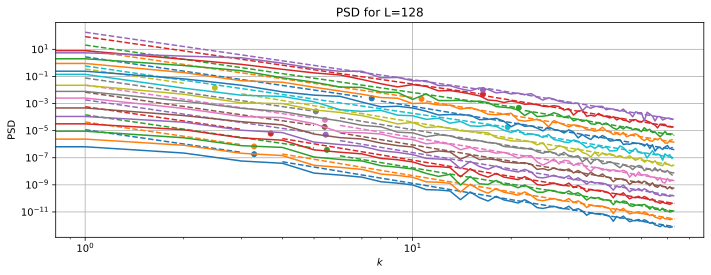

In [4]:
fig, ax = plt.subplots(figsize=(10,4))

h5_file = "../results/11-10-pieni-c_gamma/perfect/l-128/shapes.h5"

dataset = list()

for key in ['0.0001', '0.0001930697728883', '0.0003727593720314', '0.0007196856730011', '0.0013894954943731', '0.0026826957952797', '0.0051794746792312', '0.01', '0.0193069772888324', '0.0372759372031493', '0.0719685673001151', '0.1389495494373137', '0.2682695795279725', '0.5179474679231207', '1.0']:
    k_star = plot_psd_with_fit(ax, h5_file, noise_key=key, label=key, fit_range=(1,64))
    deltaR = float(key)
    dataset.append((deltaR, k_star))

ax.set_yscale('log')
ax.set_xscale('log')

ax.set_xlabel('$k$')
ax.set_ylabel('PSD')

ax.set_title('PSD for L=128')

fig.tight_layout()
# ax.legend()
ax.grid(True)

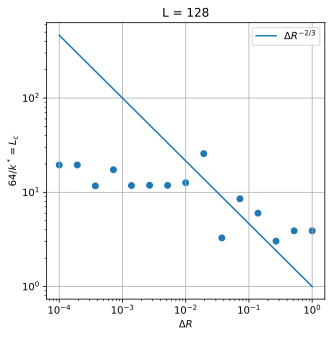

In [5]:
fig, ax = plt.subplots(figsize=(5,5))
x,y = zip(*dataset)
ax.scatter(x,np.pow(y, -1)*64)
ax.set_xscale('log')
ax.set_yscale('log')

ax.grid(True)
ax.set_ylabel('$64/k^* = L_c$')
ax.set_xlabel('$\Delta R$')
ax.set_title('L = 128')

# Theoretical predictoion L_c propto \Delta R ^{-2/3}

y_th = np.pow(x, -2/3)
ax.plot(x, y_th, label=f"$\\Delta R^{{-2/3}}$")
ax.legend()

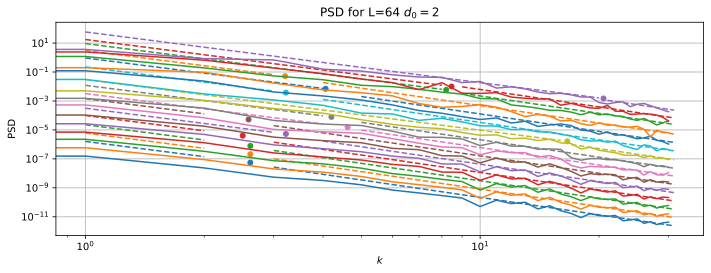

In [6]:
fig, ax = plt.subplots(figsize=(10,4))

h5_file = "../results/11-10-pieni-c_gamma/partial/l-64-d-2/shapes.h5"

dataset = list()
for key in ['0.0001', '0.0001930697728883', '0.0003727593720314', '0.0007196856730011', '0.0013894954943731', '0.0026826957952797', '0.0051794746792312', '0.01', '0.0193069772888324', '0.0372759372031493', '0.0719685673001151', '0.1389495494373137', '0.2682695795279725', '0.5179474679231207', '1.0']:

    deltaR = float(key)
    k_star = plot_psd_with_fit(ax, h5_file, noise_key=key, label=f"{deltaR:.2f}", fit_range=(1,32))
    dataset.append((deltaR, k_star))

ax.set_yscale('log')
ax.set_xscale('log')

ax.set_xlabel('$k$')
ax.set_ylabel('PSD')

ax.set_title('PSD for L=64 $d_0 = 2$')

fig.tight_layout()
ax.grid(True)

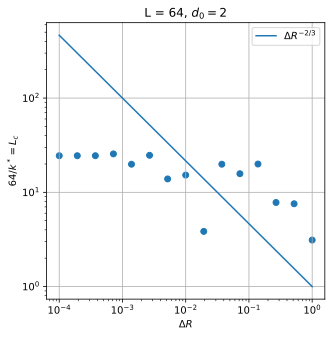

In [7]:
fig, ax = plt.subplots(figsize=(5,5))
x,y = zip(*dataset)
ax.scatter(x,np.pow(y, -1)*64)
ax.set_xscale('log')
ax.set_yscale('log')

ax.grid(True)
ax.set_ylabel('$64/k^* = L_c$')
ax.set_xlabel('$\Delta R$')
ax.set_title('L = 64, $d_0 = 2$')

# Theoretical predictoion L_c propto \Delta R ^{-2/3}

y_th = np.pow(x, -2/3)
ax.plot(x, y_th, label=f"$\\Delta R^{{-2/3}}$")
ax.legend()

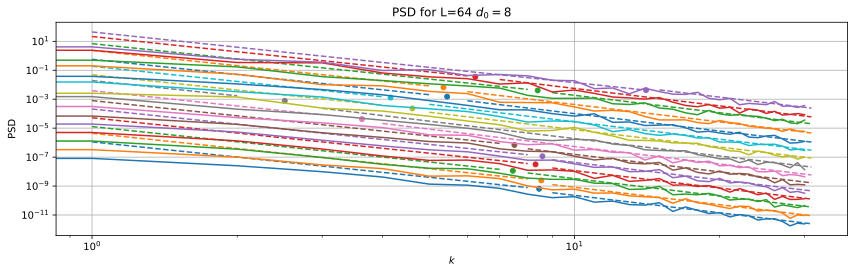

In [8]:
fig, ax = plt.subplots(figsize=(12,4))

h5_file = "../results/11-10-pieni-c_gamma/partial/l-64-d-8/shapes.h5"


dataset = list()
for key in ['0.0001', '0.0001930697728883', '0.0003727593720314', '0.0007196856730011', '0.0013894954943731', '0.0026826957952797', '0.0051794746792312', '0.01', '0.0193069772888324', '0.0372759372031493', '0.0719685673001151', '0.1389495494373137', '0.2682695795279725', '0.5179474679231207', '1.0']:

    deltaR = float(key)
    k_star = plot_psd_with_fit(ax, h5_file, noise_key=key, label=f"{deltaR:.2f}", fit_range=(1,32))
    dataset.append((deltaR, k_star))


ax.set_yscale('log')
ax.set_xscale('log')

ax.set_xlabel('$k$')
ax.set_ylabel('PSD')

ax.set_title('PSD for L=64 $d_0 = 8$')

fig.tight_layout()
ax.grid(True)

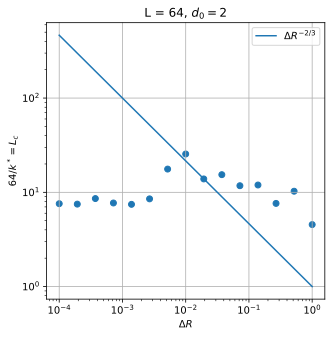

In [9]:
fig, ax = plt.subplots(figsize=(5,5))
x,y = zip(*dataset)
ax.scatter(x,np.pow(y, -1)*64)
ax.set_xscale('log')
ax.set_yscale('log')

ax.grid(True)
ax.set_ylabel('$64/k^* = L_c$')
ax.set_xlabel('$\Delta R$')
ax.set_title('L = 64, $d_0 = 2$')

# Theoretical predictoion L_c propto \Delta R ^{-2/3}

y_th = np.pow(x, -2/3)
ax.plot(x, y_th, label=f"$\\Delta R^{{-2/3}}$")
ax.legend()

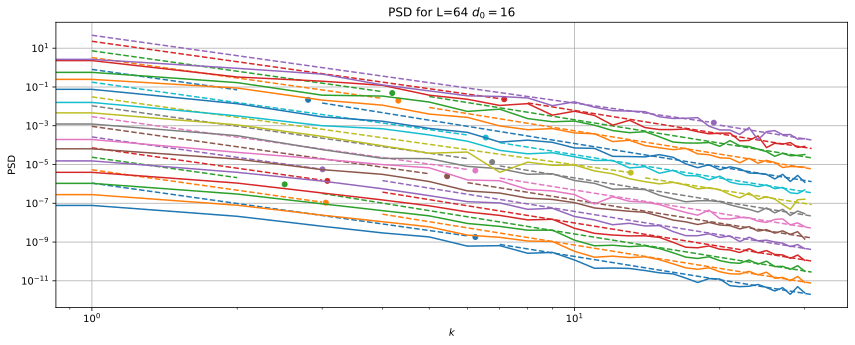

In [10]:
fig, ax = plt.subplots(figsize=(12,5))

h5_file = "../results/11-10-pieni-c_gamma/partial/l-64-d-16/shapes.h5"

dataset = list()
for key in ['0.0001', '0.0001930697728883', '0.0003727593720314', '0.0007196856730011', '0.0013894954943731', '0.0026826957952797', '0.0051794746792312', '0.01', '0.0193069772888324', '0.0372759372031493', '0.0719685673001151', '0.1389495494373137', '0.2682695795279725', '0.5179474679231207', '1.0']:
    deltaR = float(key)
    k_star = plot_psd_with_fit(ax, h5_file, noise_key=key, label=f"{deltaR:.2f}", fit_range=(1,32))
    dataset.append((deltaR, k_star))

ax.set_yscale('log')
ax.set_xscale('log')

ax.set_xlabel('$k$')
ax.set_ylabel('PSD')

ax.set_title('PSD for L=64 $d_0 = 16$')

fig.tight_layout()
ax.grid(True)

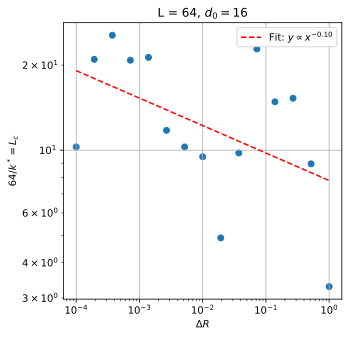

In [17]:
fig, ax = plt.subplots(figsize=(5,5))

x,y = zip(*dataset)
ax.scatter(x,np.pow(y, -1)*64)

ax.set_xscale('log')
ax.set_yscale('log')

ax.grid(True)
ax.set_ylabel('$64/k^* = L_c$')
ax.set_xlabel('$\Delta R$')
ax.set_title('L = 64, $d_0 = 16$')

# Theoretical predictoion L_c propto \Delta R ^{-2/3}

# Fit a power law y = A * x^k
# To do this, we fit a line to log(y) vs log(x)
log_x = np.log(np.array(x))
log_y = np.log(np.power(np.array(y), -1) * 64)

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(log_x, log_y)

# The fitted power law is y = exp(intercept) * x^slope
y_fit = np.exp(intercept) * np.power(np.array(x), slope)

ax.plot(x, y_fit, 'r--', label=f'Fit: $y \\propto x^{{{slope:.2f}}}$')

ax.legend()

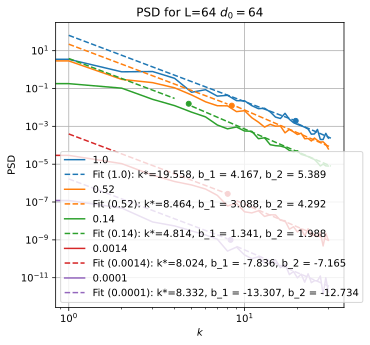

In [12]:
fig, ax = plt.subplots(figsize=(5,5))

h5_file = "../results/11-10-pieni-c_gamma/partial/l-64-d-64/shapes.h5"


plot_psd_with_fit(ax, h5_file, noise_key='1.0', label="1.0", fit_range=(1,32))
plot_psd_with_fit(ax, h5_file, noise_key='0.5179474679231207', label="0.52", fit_range=(1,32))
plot_psd_with_fit(ax, h5_file, noise_key='0.1389495494373137', label="0.14", fit_range=(1,32))
plot_psd_with_fit(ax, h5_file, noise_key='0.0013894954943731', label="0.0014", fit_range=(1,32))
plot_psd_with_fit(ax, h5_file, noise_key='0.0001', label="0.0001", fit_range=(1,32))


ax.set_yscale('log')
ax.set_xscale('log')

ax.set_xlabel('$k$')
ax.set_ylabel('PSD')

ax.set_title('PSD for L=64 $d_0 = 64$')

fig.tight_layout()
ax.legend()
ax.grid(True)

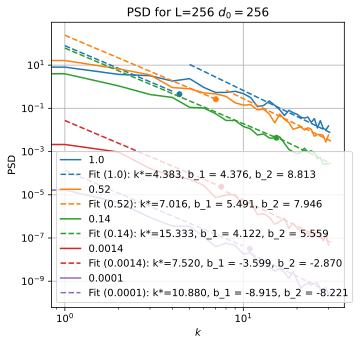

In [23]:
h5_file = "../results/11-10-pieni-c_gamma/partial/l-256-d-256/shapes.h5"

fig, ax = plt.subplots(figsize=(5,5))

plot_psd_with_fit(ax, h5_file, noise_key='1.0', label="1.0", fit_range=(1,32))
plot_psd_with_fit(ax, h5_file, noise_key='0.5179474679231207', label="0.52", fit_range=(1,32))
plot_psd_with_fit(ax, h5_file, noise_key='0.1389495494373137', label="0.14", fit_range=(1,32))
plot_psd_with_fit(ax, h5_file, noise_key='0.0013894954943731', label="0.0014", fit_range=(1,32))
plot_psd_with_fit(ax, h5_file, noise_key='0.0001', label="0.0001", fit_range=(1,32))

ax.set_yscale('log')
ax.set_xscale('log')

ax.set_xlabel('$k$')
ax.set_ylabel('PSD')

ax.set_title('PSD for L=256 $d_0 = 256$')

fig.tight_layout()
ax.legend()
ax.grid(True)


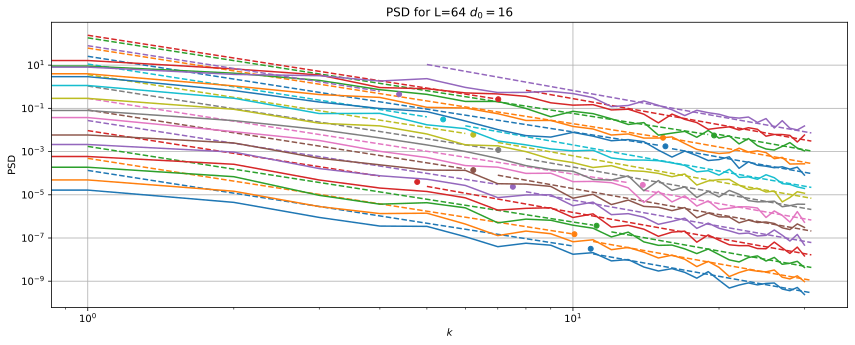

In [24]:
fig, ax = plt.subplots(figsize=(12,5))

dataset = list()
for key in ['0.0001', '0.0001930697728883', '0.0003727593720314', '0.0007196856730011', '0.0013894954943731', '0.0026826957952797', '0.0051794746792312', '0.01', '0.0193069772888324', '0.0372759372031493', '0.0719685673001151', '0.1389495494373137', '0.2682695795279725', '0.5179474679231207', '1.0']:
    deltaR = float(key)
    k_star = plot_psd_with_fit(ax, h5_file, noise_key=key, label=f"{deltaR:.2f}", fit_range=(1,32))
    dataset.append((deltaR, k_star))

ax.set_yscale('log')
ax.set_xscale('log')

ax.set_xlabel('$k$')
ax.set_ylabel('PSD')

ax.set_title('PSD for L=64 $d_0 = 16$')

fig.tight_layout()
ax.grid(True)

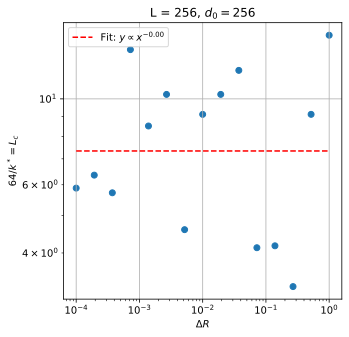

In [27]:
fig, ax = plt.subplots(figsize=(5,5))

x,y = zip(*dataset)
ax.scatter(x,np.pow(y, -1)*64)

ax.set_xscale('log')
ax.set_yscale('log')

ax.grid(True)
ax.set_ylabel('$64/k^* = L_c$')
ax.set_xlabel('$\Delta R$')
ax.set_title('L = 256, $d_0 = 256$')

# Theoretical predictoion L_c propto \Delta R ^{-2/3}

# Fit a power law y = A * x^k
# To do this, we fit a line to log(y) vs log(x)
log_x = np.log(np.array(x))
log_y = np.log(np.power(np.array(y), -1) * 64)

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(log_x, log_y)

# The fitted power law is y = exp(intercept) * x^slope
y_fit = np.exp(intercept) * np.power(np.array(x), slope)

ax.plot(x, y_fit, 'r--', label=f'Fit: $y \\propto x^{{{slope:.2f}}}$')

ax.legend()

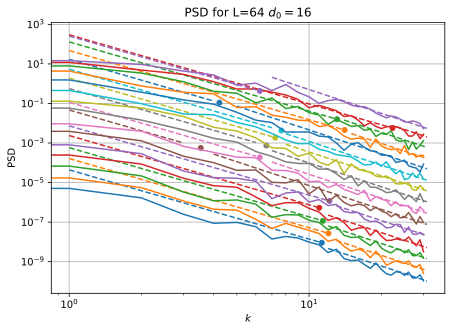

In [ ]:
fig, ax = plt.subplots()
h5_file = "../results/11-10-pieni-c_gamma/perfect/l-256/shapes.h5"

dataset = list()
for key in ['0.0001', '0.0001930697728883', '0.0003727593720314', '0.0007196856730011', '0.0013894954943731', '0.0026826957952797', '0.0051794746792312', '0.01', '0.0193069772888324', '0.0372759372031493', '0.0719685673001151', '0.1389495494373137', '0.2682695795279725', '0.5179474679231207', '1.0']:
    deltaR = float(key)
    k_star = plot_psd_with_fit(ax, h5_file, noise_key=key, label=f"{deltaR:.2f}", fit_range=(1,32))
    dataset.append((deltaR, k_star))

ax.set_yscale('log')
ax.set_xscale('log')

ax.set_xlabel('$k$')
ax.set_ylabel('PSD')

ax.set_title('PSD for L=256')

fig.tight_layout()
ax.grid(True)

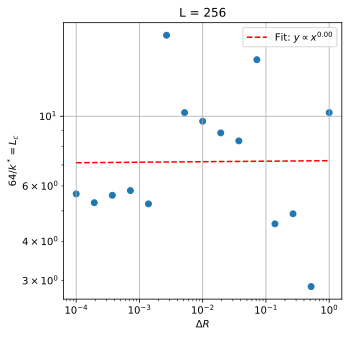

In [32]:
fig, ax = plt.subplots(figsize=(5,5))

x,y = zip(*dataset)
ax.scatter(x,np.pow(y, -1)*64)

ax.set_xscale('log')
ax.set_yscale('log')

ax.grid(True)
ax.set_ylabel('$64/k^* = L_c$')
ax.set_xlabel('$\Delta R$')
ax.set_title('L = 256')

# Theoretical predictoion L_c propto \Delta R ^{-2/3}

# Fit a power law y = A * x^k
# To do this, we fit a line to log(y) vs log(x)
log_x = np.log(np.array(x))
log_y = np.log(np.power(np.array(y), -1) * 64)

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(log_x, log_y)

# The fitted power law is y = exp(intercept) * x^slope
y_fit = np.exp(intercept) * np.power(np.array(x), slope)

ax.plot(x, y_fit, 'r--', label=f'Fit: $y \\propto x^{{{slope:.2f}}}$')

ax.legend()